I apologize for the messiness of this notebook and the code. There are probably better ways to code some of this stuff, but I didn't know how and did whatever I could.

In [1]:
import numpy as np
import matplotlib as mpl
import sys, os, argparse, linecache
from io import BytesIO
%matplotlib inline
import scipy.misc
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
#from scipy import interpolate

In [2]:
# we force the peaks to align with the peak numbers

def redefx(x,peak1): 
    for i in range(len(peak1)-1):
        x[peak1[i]:peak1[i+1]+1] = np.linspace(i,i+1,len(x[peak1[i]:peak1[i+1]+1]))

    for i in range(peak1[0]+1):
        x[peak1[0]-i] = x[peak1[0]] - i*(x[peak1[0]+1]-x[peak1[0]])

In [3]:
# we sum up all the counts between two valleys and call that sum the total count for that peak between the two valleys.

def peakSum(counts,peak1):
    peakSum = []

    for i in range(len(peak1)):
        if i == 0:
            totc = np.sum(counts[0:np.mean([peak1[i],peak1[i+1]],dtype=int)])
        elif i == len(peak1)-1:
            totc = np.sum(counts[np.mean([peak1[i],peak1[i-1]],dtype=int):])
        else:
            totc = np.sum(counts[np.mean([peak1[i-1],peak1[i]],dtype=int):np.mean([peak1[i],peak1[i+1]],dtype=int)])
        peakSum.append(totc)
    
    peakSum = np.array(peakSum)
    return peakSum

In [4]:
# This is the fit function. Its arguments are data - the full data, data2 - the pedestal, 
# peak1 - all the peak positions, and gain1 - PEgain of the data. 

# I actually run the TileCharacterization script first to get the peak positions and gain1, and
# copy paste those values to this notebook.

def Fit(data,data2,peak1,gain1):
    counts=data['counts']
    x = np.arange(counts.size)
    x = x.astype(float)

    peak1 = np.append(peak1,np.arange(peak1[-1]+gain1,np.amax(x),gain1)) # predict positions of peaks after the
                                                                         # 20th peak based on gain 
    peak1 = peak1.astype(int)
    
    counts2=data2['counts']
    
    peakSum1=peakSum(counts,peak1)
    peakSum2=peakSum(counts2,peak1)
    
    # I normalized the first peak of the pedestal to the first peak of the data before doing pedestal subtraction.
    # This is to prevent getting a super large negative number after the subtraction.
    normfac = peakSum1[0]/peakSum2[0] 
    peakSum2 = peakSum2 * normfac
    peakSub = peakSum1 - peakSum2
    
    PEyield = np.sum(peakSub*range(len(peakSub)))
    normaliza = np.sum(peakSub[1:])
    PEyield = PEyield/normaliza
    ran = np.arange(0,len(peakSum1)/3)
    
    nonNegInd = []
    for i in range(peakSub.size):
        if i > 4 and peakSub[i] > 10: # i > 4 is the cut we make. We start fitting after peak 4.
            nonNegInd.append(i)

    peakSub18 = peakSub[nonNegInd]
    xp18 = np.array(nonNegInd)

    # curve_fit is the curve fitting module that I used. func is the best fit function. func is defined below,
    # not in this particular cell.
    popt, pcov = curve_fit(func, xp18, np.log(peakSub18),maxfev=200000) # popt is the optimum fitting parameters
    ran = np.linspace(5,np.amax(xp18),1000)
    #plt.plot(x[ran],counts[ran],'y')
    #plt.plot(x[ran],newcounts2[ran],'r')
    mpl.rc("font", family="serif", size=16)
    plt.figure(figsize=(15,8)) 
    plt.plot(xp18,np.log(peakSub18),'go')
    plt.plot(ran, func(ran, *popt), 'm')
    plt.legend(["After Pedestal Subtraction","Quadratic Fit"])
    plt.xlabel("Peak Number")
    plt.ylabel("Log of Count")

    print popt

# Fitting a Quadratic Function

a and b are:
[-2.10417914e-03  8.72455958e+00]


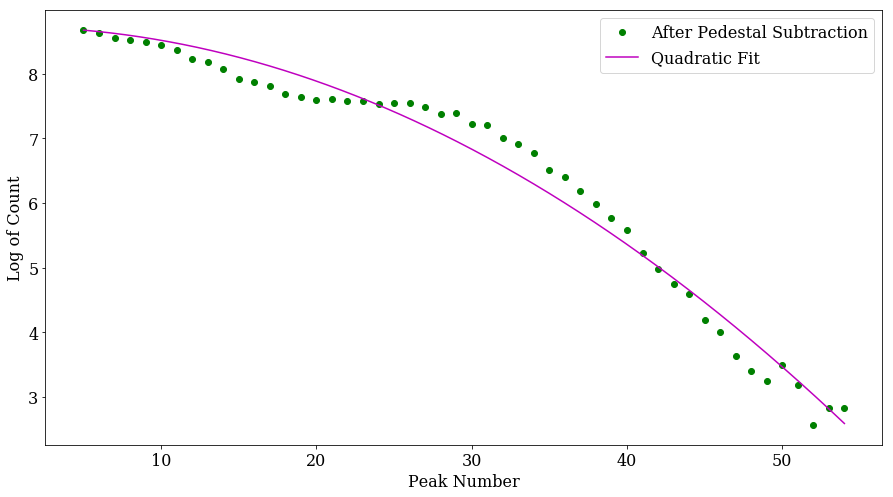

In [5]:
# Tile 48

# Tile 48 is the reference tile. We first fit the function a*x^2 + b and get the best fit values for a and b.
# After that, we use these values for a and b, and fit sqrt(1/(2p))*(a*(p*x)^2+b)+c to the other damaged tiles.
# We record the values for p. p = 1/k, where k is the damage coefficient.

data = np.genfromtxt("/home/keane/Keane/SummerResearch2018/radtest/After_Cleaning_SiPM/48_1_May21.Spe",delimiter=" ",names=['counts'],skip_header=12,skip_footer=15)
data2 = np.genfromtxt("/home/keane/Keane/SummerResearch2018/radtest/After_Cleaning_SiPM/48_0_May21.Spe",delimiter=" ",names=['counts'],skip_header=12,skip_footer=15)
peak1 = np.array([  29,   86,  144,  203,  263,  322,  382,  443,  502,  560,  621,  680,  741,  800,
  861,  916,  978, 1037, 1097, 1156, 1216])
gain1 = 59.5

def func(x,a,b):
        return a*(x**2)+b

print ("a and b are:")
Fit(data,data2,peak1,gain1)

1/k and c are:
[1.22030027 4.81259563]


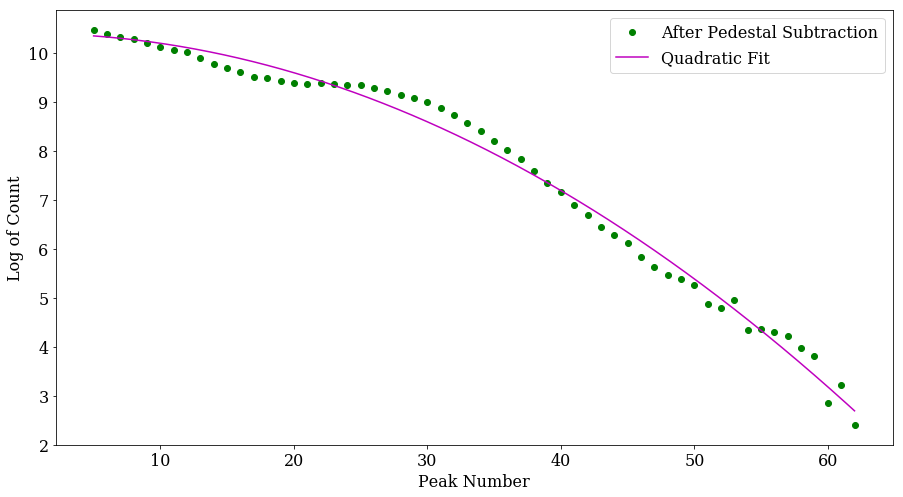

In [11]:
# Tile 18

data = np.genfromtxt("/home/keane/Keane/SummerResearch2018/radtest/After_Cleaning_SiPM/18_1_Jul18.Spe",delimiter=" ",names=['counts'],skip_header=12,skip_footer=15)
data2 = np.genfromtxt("/home/keane/Keane/SummerResearch2018/radtest/After_Cleaning_SiPM/18_0_Jul18.Spe",delimiter=" ",names=['counts'],skip_header=12,skip_footer=15)

peak1 = np.array([  38,   91,  146,  205,  266,  324,  383,  439,  500,  560,  619,  674,  735,  798,
  853,  911,  971, 1029, 1088, 1147])

gain1 = 58.88

def func(x,p,c):
        return np.sqrt(1/(2*p))*((-2.104e-03)*(p*x)**2+(8.725))+c

print ("1/k and c are:")
Fit(data,data2,peak1,gain1)

1/k and c are:
[1.21782942 4.78838389]


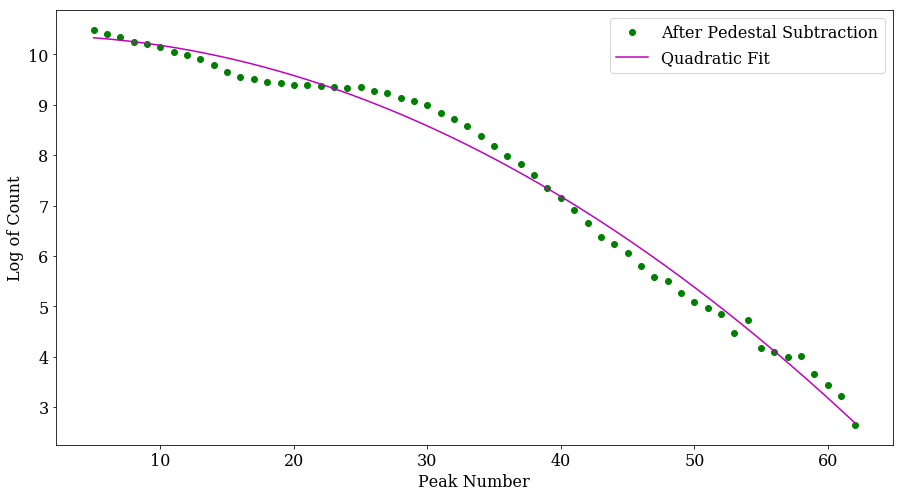

In [7]:
# Tile 19

data = np.genfromtxt("/home/keane/Keane/SummerResearch2018/radtest/After_Cleaning_SiPM/19_1_Jul18.Spe",delimiter=" ",names=['counts'],skip_header=12,skip_footer=15)
data2 = np.genfromtxt("/home/keane/Keane/SummerResearch2018/radtest/After_Cleaning_SiPM/19_0_Jul18.Spe",delimiter=" ",names=['counts'],skip_header=12,skip_footer=15)

peak1 = np.array([  38,   91,  146,  203,  265,  322,  380,  441,  498,  555,  614,  673,  728,  788,
  847,  907,  960, 1017, 1075, 1133, 1191])

gain1 = 57.75

def func(x,p,c):
        return np.sqrt(1/(2*p))*((-2.104e-03)*(p*x)**2+(8.725))+c

print ("1/k and c are:")
Fit(data,data2,peak1,gain1)

1/k and c are:
[2.41915825 6.84532008]


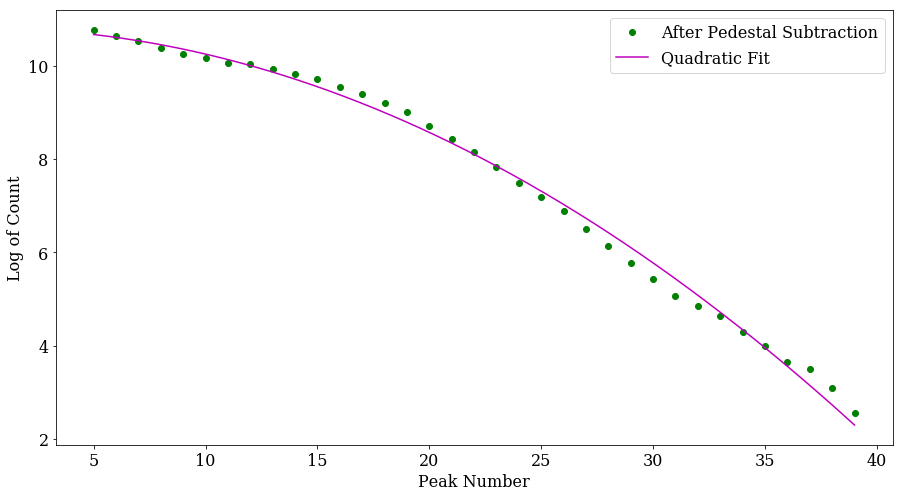

In [8]:
# Tile 68

data = np.genfromtxt("/home/keane/Keane/SummerResearch2018/radtest/After_Cleaning_SiPM/68_1_Jun11.Spe",delimiter=" ",names=['counts'],skip_header=12,skip_footer=15)
data2 = np.genfromtxt("/home/keane/Keane/SummerResearch2018/radtest/After_Cleaning_SiPM/68_0_Jun11.Spe",delimiter=" ",names=['counts'],skip_header=12,skip_footer=15)

peak1 = np.array([  31,   84,  138,  194,  251,  307,  361,  418,  475,  530,  585,  639,  694,  753,
  807,  863,  917,  972, 1027, 1082, 1138])

gain1 = 55.25


def func(x,p,c):
        return np.sqrt(1/(2*p))*((-2.104e-03)*(p*x)**2+(8.725))+c

print ("1/k and c are:")
Fit(data,data2,peak1,gain1)

1/k and c are:
[4.72593242 8.11300766]


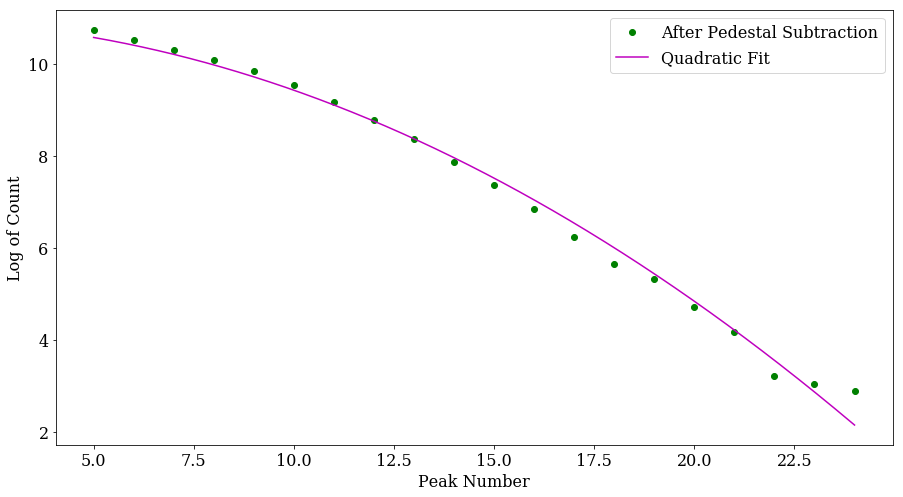

In [9]:
# Tile 51

data = np.genfromtxt("/home/keane/Keane/SummerResearch2018/radtest/After_Cleaning_SiPM/51_1_Jul18.Spe",delimiter=" ",names=['counts'],skip_header=12,skip_footer=15)
data2 = np.genfromtxt("/home/keane/Keane/SummerResearch2018/radtest/After_Cleaning_SiPM/51_0_Jul18.Spe",delimiter=" ",names=['counts'],skip_header=12,skip_footer=15)
peak1 = np.array([  37,   90,  145,  204,  261,  322,  379,  435,  492,  548,  608,  664,  722,  781,
  840,  900,  959, 1021, 1064, 1122, 1180])

gain1 = 58.38

def func(x,p,c):
        return np.sqrt(1/(2*p))*((-2.104e-03)*(p*x)**2+(8.725))+c

print ("1/k and c are:")
Fit(data,data2,peak1,gain1)

1/k and c are:
[12.1626942   8.58197945]


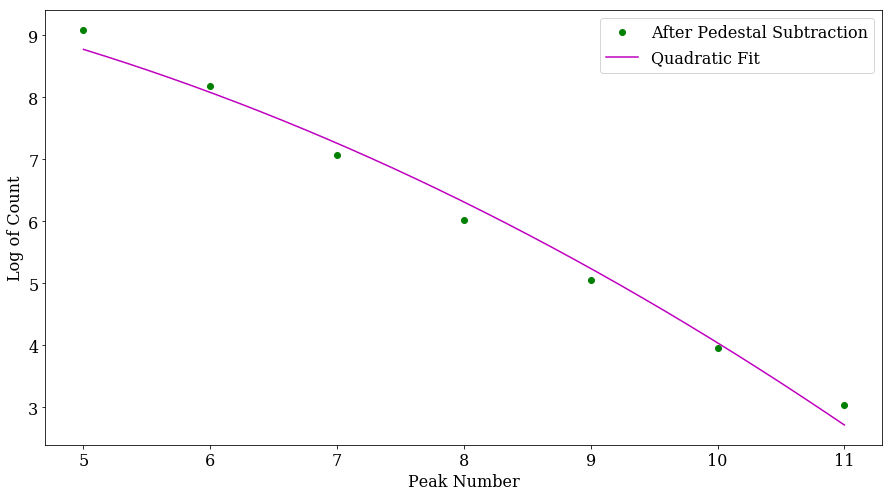

In [10]:
# Tile 66

data = np.genfromtxt("/home/keane/Keane/SummerResearch2018/radtest/After_Cleaning_SiPM/66_1_Jul18.Spe",delimiter=" ",names=['counts'],skip_header=12,skip_footer=15)
data2 = np.genfromtxt("/home/keane/Keane/SummerResearch2018/radtest/After_Cleaning_SiPM/66_0_Jul18.Spe",delimiter=" ",names=['counts'],skip_header=12,skip_footer=15)

peak1 = np.array([ 37,  90, 146, 203, 261, 318, 374, 442, 485, 542, 599, 656, 713, 770, 827, 884]
)

gain1 = 57.00

def func(x,p,c):
        return np.sqrt(1/(2*p))*((-2.104e-03)*(p*x)**2+(8.725))+c

print ("1/k and c are:")
Fit(data,data2,peak1,gain1)

## Comparing Damage Coefficient from Test Beam with that from Source

[ 1.02212516 -0.12362673]


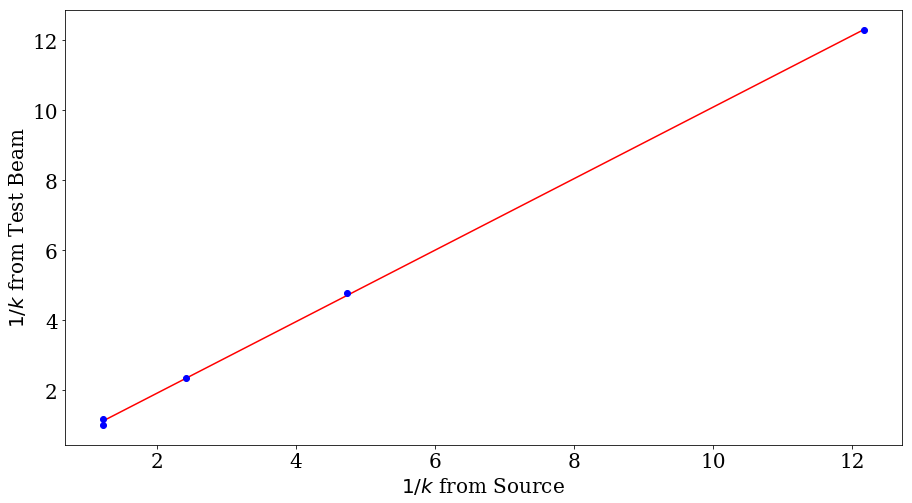

In [13]:
sdata = np.array([1.220,1.218, 2.419, 4.726, 12.163])   # 1/k values from source, k is the damage coefficient
tbdata = np.array([1.009,1.180,2.361,4.773,12.286])     # 1/k values from test beam

def func(x,a,b):  # function used to fit the data
    return a*x+b # a linear function

popt, pcov = curve_fit(func, sdata, tbdata) # popt is the optimum fitting parameters

plt.figure(figsize=(15,8)) 
mpl.rc("font", family="serif", size=20)
plt.ylabel("$1/k$ from Test Beam")
plt.xlabel("$1/k$ from Source")
plt.plot(sdata, func(sdata, *popt), 'r')
plt.plot(sdata, tbdata,'bo')

print(popt)
plt.show()